In [10]:
## Load Libraries ##
import pandas as pd 
import os
import re
from wordcloud import WordCloud ##pip install wordclod
import gensim ## pip install gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora

## LOAD DATA
## change directory as needed
os.chdir('/Users/erikaatanassov/airplane-interior-services/data')
review = pd.read_csv('tripadvisor_reviews.csv',sep="|", usecols=['comment'])


In [12]:
## Text Processing ##
# Remove punctuation
review['text'] = \
review['comment'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
review['text'] = \
review['text'].map(lambda x: x.lower())
# Print out the first rows of papers
review['text'].head()

0    worst check-in experience today february 8th 2...
1    choose another airline drive get a boat walk a...
2    air france is the worst for dealing with custo...
3    modern cabin comfortable seat cold & thoughtle...
4    fine in the air terrible at the airports cdg-c...
Name: text, dtype: object

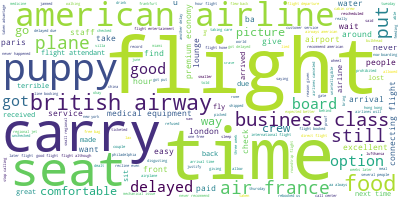

In [14]:
### Create a Wordcloud ##
# Join the different processed titles together.
long_string = ','.join(list(review['text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [25]:
## Removing Stop Words ##

stop_words = stopwords.words('english')
## add additional words that may appear in every review or unesful regarding AIS
stop_words.extend(['flight', 'delayed'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = review.text.values.tolist()
data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words)

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


/Users/erikaatanassov/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/erikaatanassov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['worst', 'check', 'experience', 'today', 'february', 'th', 'lax', 'tried', 'check', 'amsterdam', 'provided', 'documents', 'pcr', 'test', 'antigen', 'test', 'stating', 'negative', 'well', 'passport', 'work', 'permit', 'employer', 'however', 'one', 'supervisors', 'said', 'needed', 'ind', 'immigration']


In [28]:
## LDA Modeling ##
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/Users/erikaatanassov/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[(0,
  '0.034*"carry" + 0.018*"delay" + 0.013*"would" + 0.011*"another" + '
  '0.011*"attendant" + 0.009*"given" + 0.009*"option" + 0.009*"equipment" + '
  '0.009*"medical" + 0.008*"plane"'),
 (1,
  '0.012*"seats" + 0.012*"class" + 0.010*"economy" + 0.010*"service" + '
  '0.010*"food" + 0.009*"business" + 0.009*"air" + 0.008*"seat" + '
  '0.008*"lufthansa" + 0.007*"plane"'),
 (2,
  '0.015*"good" + 0.013*"air" + 0.012*"would" + 0.011*"service" + '
  '0.011*"airline" + 0.009*"france" + 0.009*"carry" + 0.008*"food" + '
  '0.008*"staff" + 0.007*"fly"'),
 (3,
  '0.035*"good" + 0.019*"airlines" + 0.015*"food" + 0.013*"a

In [22]:
## Appending Topic to Review ##
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/Users/erikaatanassov/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.7269,"flight, air, get, time, service, good, late, f...",worst check-in experience today february 8th 2...
1,1,3.0,0.3491,"flight, air, get, time, service, good, late, f...",choose another airline drive get a boat walk a...
2,2,3.0,0.6801,"flight, air, get, time, service, good, late, f...",air france is the worst for dealing with custo...
3,3,4.0,0.7684,"flight, good, service, food, comfortable, time...",modern cabin comfortable seat cold & thoughtle...
4,4,4.0,0.5407,"flight, good, service, food, comfortable, time...",fine in the air terrible at the airports cdg-c...
5,5,4.0,0.6309,"flight, good, service, food, comfortable, time...",air france lax desk is the best othman at air...
6,6,3.0,0.6955,"flight, air, get, time, service, good, late, f...",air france protect airfrance :\n\n« our air fr...
7,7,4.0,0.5186,"flight, good, service, food, comfortable, time...",if i could leave a 0 out 5 i would havent even...
8,8,3.0,0.6364,"flight, air, get, time, service, good, late, f...",awful from paris probably the worst flight eve...
9,9,4.0,0.6976,"flight, good, service, food, comfortable, time...",worst experience till date they made me check ...
